
# 1. Libraries setup

### Import the fastai library

In [6]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

### Import all the other libraries needed

In [7]:
import os # Create directories, list files
import zipfile # Extract compressed files
import numpy as np # Linear algebra, sorting and selecting
import pandas as pd # Dataframes and csv I/O
import matplotlib.pyplot as plt # Plotting histograms
from math import exp
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

<br>
<br>
# 2. Environment setup

### Environment

```
./input
│   train.csv    
│
└─── train
│   │   train_whale1.jpg
│   │   train_whale2.jpg
│   
│   
└─── test
│   │   test_whale1.jpg
│   │   test_whale2.jpg
│  
│   
└─── submission
    │   submission1.csv
    │   submission2.csv
```

### Initialize the enviroment variables

In [8]:
INPUT_DIR = ".\input"
DOWNLOAD_DIR = "C:\\Users\\David\\.kaggle\\competitions\\whale-categorization-playground"

### Download the data from kaggle

Instructions to use the kaggle API: https://github.com/Kaggle/kaggle-api

In [9]:
if (os.system("kaggle competitions download -c whale-categorization-playground") == 0): print("Compressed files ready")

Compressed files ready


### Extract the data to the input directory

In [10]:
os.listdir(DOWNLOAD_DIR)

print("Extracting the training set...")
train_zip = zipfile.ZipFile(DOWNLOAD_DIR+"\\train.zip", mode="r")
train_zip.extractall(INPUT_DIR)
train_zip.close()

print("Extracting the test set...")
test_zip = zipfile.ZipFile(DOWNLOAD_DIR+"\\test.zip", mode="r")
test_zip.extractall(INPUT_DIR)
test_zip.close()

print("All files extracted succesfully")

Extracting the training set...
Extracting the test set...
All files extracted succesfully


### Move the train.csv file and create the submission directory

In [11]:
if not os.path.exists(INPUT_DIR+"\\train.csv"):
    os.rename(DOWNLOAD_DIR+"\\train.csv", INPUT_DIR+"\\train.csv")
print("train.csv ready")
    
if not os.path.exists(INPUT_DIR+"\\submission"): 
    os.mkdir(INPUT_DIR+"\\submission")
print("sumbmission directory ready")

train.csv ready
sumbmission directory ready


### Check everything is correct

In [12]:
expected_dir = ['submission','train',  'test', 'train.csv']
current_dir = os.listdir(INPUT_DIR)
print(current_dir)
if set(expected_dir).issubset(set(current_dir)): print("Everything is correct")

['models', 'prova', 'submission', 'test', 'tmp', 'train', 'train.csv']
Everything is correct


<br>
<br>
# 3. Data exploration

<br>
## 3.1 Training dataframe

### Training dataframe creation

Generate the pandas dataframe that will link each image to the corresponding whale from the csv file.
Show some basic info.

In [13]:
train_df = pd.read_csv(INPUT_DIR + "/train.csv")
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9850 entries, 0 to 9849
Data columns (total 2 columns):
Image    9850 non-null object
Id       9850 non-null object
dtypes: object(2)
memory usage: 154.0+ KB


### Training dataframe structure


As we can see we have two columns, corresponding to the whale image path and the whale identifier.

In [14]:
train_df.head()

,Image,Id
0,00022e1a.jpg,w_e15442c
1,000466c4.jpg,w_1287fbc
2,00087b01.jpg,w_da2efe0
3,001296d5.jpg,w_19e5482
4,0014cfdf.jpg,w_f22f3e3


<br>
## 3.2 Training data visualitzation

### Welcoming whale

Load a random whale image to welcome us.

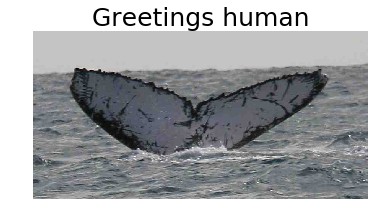

In [15]:
welcoming_whale = train_df.sample(1)["Image"].values[0]
image = plt.imread(f'{INPUT_DIR}/train/{welcoming_whale}')
image_plot = plt.imshow(image)
plt.axis("Off")
title = plt.title("Greetings human", fontsize=25)

<br>
### Training set images visualitzation

Create a function to retrieve n random whales from the dataset.

In [16]:
def get_random_whales(n):
    """Returns iterable of n lists of random whale images and whale id pairs from the training dataset
        [img_name1, img1], [img_name2, img2], ..., [img_name3, img3]
    """
    train_sample = train_df.sample(n)
    identifiers = [whale_id for whale_id in train_sample["Id"]]
    images = [plt.imread(f'{INPUT_DIR}/train/{image_name}')  for image_name in train_sample["Image"]]
    whales = zip(identifiers, images)
    return whales

<br>
Create a function to display n whales with the corresponding identifier.

In [17]:
def plot_random_whales(n):
    """Plots n random whales with its corresponding identifier
    """
    whales = get_random_whales(n)
    columns = 5
    rows = (n // columns) + 1
    width, height = columns * 3, rows * 3
    figure = plt.figure(figsize=(width,height))
    for i, whale in enumerate(whales):
        subplot = figure.add_subplot(rows,columns,i+1)
        subplot.axis("Off")
        plt.title(whale[0])
        plt.imshow(whale[1])

<br>
Let's see some whales

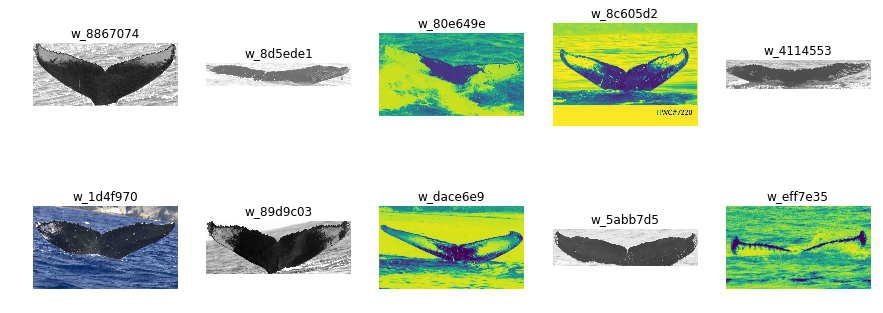

In [18]:
plot_random_whales(10)

<br>
## 3.3 Training data analysis

### Number of training examples and categories

In [19]:
n_train_images = train_df["Image"].count()
categories = train_df["Id"].unique()
n_categories = len(train_df["Id"].unique())
ratio_images_per_category = round(n_train_images / n_categories, 2)
print(f"Number of training images: {n_train_images}")
print(f"Number of categories: {n_categories}")
print(f"Average images per category: {ratio_images_per_category}")

Number of training images: 9850
Number of categories: 4251
Average images per category: 2.32


As we can see, we don't have many test cases per category. We will use a histogram to visualize it better.

<br>
## Histogram:
### Number of images per category

We count the number of images each category has (images_per_category). <br>
We compute the pair of lists:
 - number of images
 - number of categories with that number of images.

In [20]:
images_per_category = train_df["Id"].value_counts().values
n_images, n_categories_with_n_images = np.unique(images_per_category, return_counts=True)

Plot the corresponding histogram

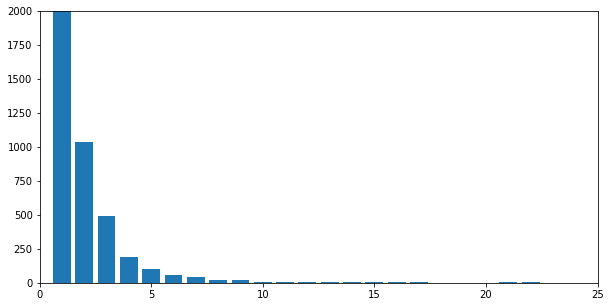

In [21]:
plt.figure(figsize=(10, 5))
plt.bar(n_images, n_categories_with_n_images)
plt.axis((0,25,0,2000))
plt.show()

One huge problem with this dataset is the number of images per category.
 - First, it's very hard to generalize from such small number of cases
 - Second, if we include all the images for one particular category in the validation set, then our trained network won't have the right output dimensionality (this will break our model as we will see later)

## Data augmentation

Because we have so few training cases per category we need to do some agressive data augmentation so the model can generalize.

The pipeline for data augmentation is described as follows:
 - Get an array with the categories.
 - For each category, obtain a list with the filenames.
 - Define the transformation function.

## Generate dictionary {category : image filenames}

The objective is to obtain a dictionary that links each category to all the image filenames belonging to that category.<br>

In [22]:
categories

array(['w_e15442c', 'w_1287fbc', 'w_da2efe0', ..., 'w_6249155', 'w_2ceab05', 'w_b9bfd4e'], dtype=object)

The following statment creates a dataframe of all the image filenames that belong to that category. <br>
Localize all the "Image" elements where the "Id" element equals to the category and create a dataframe.

In [23]:
category_df = train_df.loc[train_df["Id"] == categories[2], ["Image"]] # 2 is just a random number
category_df

,Image
2,00087b01.jpg
1094,1c2e3696.jpg
1542,28ff06e7.jpg
1704,2d1f2fd3.jpg
2369,3db2b50d.jpg
4237,6f3b1c6d.jpg
5023,82987a45.jpg
6314,a40da07c.jpg
6784,b002c2c3.jpg
6917,b35cb9b8.jpg


Then we select the elements from the "Image" column and cast them to a list.

In [24]:
category_image_filenames = list(category_df["Image"])
category_image_filenames

['00087b01.jpg',
 '1c2e3696.jpg',
 '28ff06e7.jpg',
 '2d1f2fd3.jpg',
 '3db2b50d.jpg',
 '6f3b1c6d.jpg',
 '82987a45.jpg',
 'a40da07c.jpg',
 'b002c2c3.jpg',
 'b35cb9b8.jpg',
 'bd912af5.jpg']

Putting all together with dictionary comprehension

In [25]:
category_filenames_dict = {category : list(train_df.loc[train_df["Id"] == category, ["Image"]]["Image"]) for category in categories}

In [26]:
category_filenames_dict[categories[42]]

['010f1fe2.jpg']

## Data augmentation with keras

Define the data generator isntance that will apply the transformations to our dataset.

In [27]:
data_generator = ImageDataGenerator(
                    rotation_range=40,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range=0.2,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    fill_mode='nearest')

Create the augmentations director

In [1]:
if not os.path.exists(INPUT_DIR+"\\train_augmented"): 
    os.mkdir(INPUT_DIR+"\\train_augmented")
print("Augmentations directory ready")

NameError: name 'os' is not defined

Let's load an image

In [50]:
train_df["Image"][42]

'00ec0dcd.jpg'

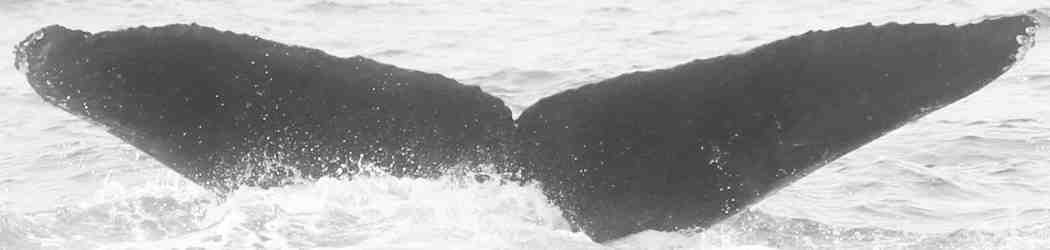

In [56]:
img = load_img(f'{INPUT_DIR}\\train\\{train_df["Image"][42]}')
img

Let's create a batch of augmented images from that previous image

In [59]:
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

In [61]:
i = 0
for batch in data_generator.flow(x, batch_size=1,
                          save_to_dir='.\\input\\train_augmented', save_prefix='cat', save_format='jpeg'):
    i += 1
    if i > 20:
        break

<br>
<br>
# 4. Model training

Building a succesfull neural network is an iterative process. We shouldn't expect to come up with a magical idea that will make a great network from the start. Also we shouldn't make decisions based on "gut feelings" or "divine visions".

<br>
## 4.1 First iteration: Basic Model

My first priority is to build a basic and dirty classfier that will output something.
That something doesn't have to be great, it can be just above garbage, but thats more than enough to extract some metrics that will drive our decisions much better.
For that reason, I won't bother for augmentations, tricky algorithms or anything more than the very basics at this point. I will just focus on predicting something I can upload to kaggle.

### Architecture
The chosen architecture is resnet34, it comes pretrained with a huge imagenet dataset and it's not too complex.

In [29]:
arch = resnet34

### Transformations size
Resnet34 was trained on mostly 224·224 to 300·300 images sizes. For that reason, transforming the training images to that size should result in decent result.

In [30]:
tfms = tfms_from_model(arch, 224)

### Validation set
For now, we will go with the standard 20% of the training set

In [79]:
val_idxs = get_cv_idxs(n_train_images, val_pct=0.001)

### Data transformation
Now we can adapt the training set images to train a neural net based on the previous options.<br>
We don't have folders for each category so we will create the data from the csv file.

In [80]:
data = ImageClassifierData.from_csv(path="./input", folder="train", val_idxs=val_idxs, csv_fname="./input/train.csv", test_name="test", skip_header=True, tfms=tfms)

### Learning rate
Create a pretrained convolutional neural network instance. 

In [81]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


Compute the learning rate related info

In [82]:
learn.lr_find()

 92%|█████████▏| 142/154 [00:01<00:00, 95.86it/s, loss=61.1]


Our learning instance has a scheduler that exponentially increases the learning rate with each batch.<br>
Let's plot how this sheduler increses the learning rate with each iteration.

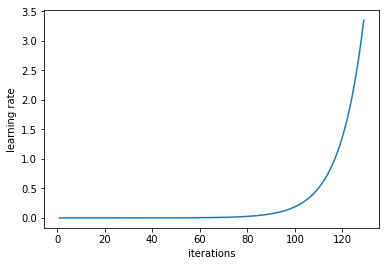

In [35]:
learn.sched.plot_lr()

Check how the loss decreases faster for a bigger learning rate until it becomes unstable.

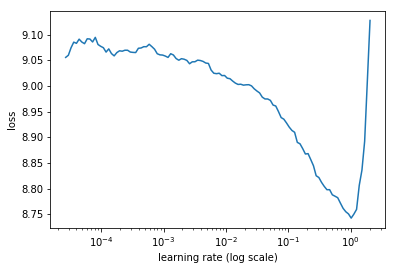

In [36]:
learn.sched.plot()

A learning rate of 0.1 seems like a reasonable choice.

### Training
Train the model with the chosen learning rate for 2 epochs or cycles.

In [83]:

learn.fit(lrs=0.1, n_cycle=2)

epoch      trn_loss   val_loss   accuracy                    
    0      7.822618   7.781889   0.0       
    1      6.810405   7.31912    0.0                        



[7.3191199, 0.0]

<br>
<br>
# 5. Model predictions

### 5.1 Understanding the output

We should be worried about the chosen activation function for our last layer, as it's nature is going to greatly define the neural network.<br>
Let's check out what the last layer activation function is.

In [38]:
learn[-1]

LogSoftmax()

The last layer outputs the logarithm of the softmax function of the activations of the previous layer (read that again).

In this case the softmax function presents the following properties:
   - The sum of all the values of the output are equal to 1
   - It tends to "choose" only one category over the others on an exponential rate

Now let's think about our current dataset. This neural network has to predict <b>which</b> whale is in the image.
So we could see our prediction as a mutual exclusion problem where it only makes sense to predict <b>one</b> whale.
This goes well with the properties of the softmax function, so it seems like a reasonable choice to use as the last layer.


#### Logarithm of the softmax function

$$L_i = \log\left(\frac{e^{i}}{ \sum_j e^{j} }\right)$$
The output of the softmax function ranges from 0 to 1:<br>
 - 0 corresponds to a very unlikely match<br>
 - 1 corresponds to a almost certain match

The output of the logarithm of the softmax function ranges from -inf to 0:<br>
 - -inf corresponds to a very unlikely match<br>
 - 0 corresponds to a almost certain match


### 5.2 Making the predictions

We set the is_test flag to True to tell the model to predict on the test set.<br>

In [84]:
test_name = "test"
test_predictions = learn.predict(is_test=True)

The prediction is represented as an array of predictions for each of the categories  sorted in the appearing order in the csv file.<br>
In this case, the model has 4251 categories, so the output for an image should be an array of 4251 items.<br>


In [85]:
print(f"The array of predictions for each category: {test_predictions[42]}")
print(f"The size of the array is: {np.size(test_predictions[42])}")

The array of predictions for each category: [-4.30915 -8.48228 -8.63987 ..., -9.52228 -7.22795 -9.06952]
The size of the array is: 4251


So the prediction for m test cases will result in a list of the predictions of each image for each category.<br>
It can be thought as a m*c matrix

In [86]:
np.shape(test_predictions)

(15610, 4251)

### 5.3 Submission pipeline

In this kaggle competition we are told to give the 5 more likely categories for each test case. The pipeline is described as follows:
 - Extract the 5 best predicted category indexes for each test case.
 - Match the indexes with the category identifier from the original "Id" column of the dataframe.
 - Write our predictions in a csv file.


### 5.4 Extracting the categories indexes

In [87]:
def categories_indexes_wrapper(prediction):
    """Returns an array with the indexes of the 5 most likely categories
    for a prediction"""
    prediction_categories_index = np.argpartition(prediction, -5)[-5:]
    return prediction_categories_index

In [88]:
prediction_categories_index = list(map(categories_indexes_wrapper, test_predictions))
print(prediction_categories_index[42])

[2039 1923 2388 2002    0]


### 5.5 Linking the categories

Extract the categories identifiers from the categories indexes for a prediction.

In [89]:
def categories_from_index(prediction_categories_index):
    prediction_categories = [data.classes[index] for index in prediction_categories_index]
    return prediction_categories

Apply to all the predictions.

In [90]:
predicted_cat = list(map(categories_from_index, prediction_categories_index))
print(f"An example of a prediction: {predicted_cat[42]}")

An example of a prediction: ['w_7a53e0c', 'w_73d5489', 'w_8e23e4c', 'w_7885601', 'new_whale']


### 5.6 Creating the submission file

Following the submission example from kaggle we need:
 - a column with the names of the images with an "Image" header
 - a column with the 5 predicted space separated categories with an "Id" header

In [91]:
images_names_column = [image_file_name[5:] for image_file_name in data.test_ds.fnames]
predicted_categories_column = list(map(" ".join, predicted_cat))

In [92]:
print(data.classes[0:10])
print(list(categories[0:10]))

['new_whale', 'w_0013924', 'w_001ebbc', 'w_002222a', 'w_002b682', 'w_002dc11', 'w_0087fdd', 'w_008c602', 'w_009dc00', 'w_00b621b']
['w_e15442c', 'w_1287fbc', 'w_da2efe0', 'w_19e5482', 'w_f22f3e3', 'w_8b1ca89', 'w_eaad6a8', 'new_whale', 'w_3d0bc7a', 'w_50db782']


Construct the pandas dataframe.<br>
We need to define the order of the columns to match the submission example by kaggle.

In [93]:
predictions_df  = pd.DataFrame(data = {"Image":images_names_column, "Id": predicted_categories_column}, columns=["Image", "Id"])
predictions_df.head()

,Image,Id
0,00029b3a.jpg,w_7875b79 w_e548eb7 w_f3d98bc w_b688397 new_whale
1,0003c693.jpg,w_d88328d w_b7d5069 new_whale w_2d99a0c w_bb2d34d
2,000bc353.jpg,w_8b56cb1 w_02facde w_9ea2cc3 new_whale w_18eee6e
3,0010a672.jpg,w_4e52a49 w_f18df18 w_fba3bde w_cae7677 new_whale
4,00119c3f.jpg,w_9875c12 w_434ad6a w_43be268 w_9ea2cc3 w_e54feba


Create the submission file without the index column.

In [94]:
predictions_df.to_csv("submission3.csv",index=False)